<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Pintor Ochoa, Lyha Espinosa García

**Fecha:** 28 de abril de 2021.

**Expediente** : if72622, if721861.
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 9: Clase 21

## Enunciado de tarea 
> Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y compararlo con el valor teórico de la ecuación de Black-Scholes.

### Solución Lyha Espinosa

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

SyntaxError: invalid syntax (<ipython-input-1-9d1c0c122db9>, line 2)

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

Descarga de datos de opciones de Microsoft 

In [3]:
micro = web.YahooOptions('MSFT')
micro_opt = micro.get_all_data().reset_index()
micro_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-04-30,240.0,put,MSFT210430P00240000,...,2021-04-27 17:43:11,2021-04-27 17:25:07,"{'contractSymbol': 'MSFT210430P00240000', 'str..."
2021-04-30,270.0,call,MSFT210430C00270000,...,2021-04-27 17:43:11,2021-04-27 17:27:38,"{'contractSymbol': 'MSFT210430C00270000', 'str..."
2021-04-30,237.5,call,MSFT210430C00237500,...,2021-04-27 17:43:11,2021-04-27 17:22:32,"{'contractSymbol': 'MSFT210430C00237500', 'str..."
2021-04-30,237.5,put,MSFT210430P00237500,...,2021-04-27 17:43:11,2021-04-27 17:26:00,"{'contractSymbol': 'MSFT210430P00237500', 'str..."
2021-04-30,295.0,call,MSFT210430C00295000,...,2021-04-27 17:43:11,2021-04-27 16:27:24,"{'contractSymbol': 'MSFT210430C00295000', 'str..."
...,...,...,...,...,...,...,...
2023-06-16,285.0,call,MSFT230616C00285000,...,2021-04-27 17:43:16,2021-04-27 13:53:02,"{'contractSymbol': 'MSFT230616C00285000', 'str..."
2023-06-16,115.0,put,MSFT230616P00115000,...,2021-04-27 17:43:16,2021-04-26 16:04:29,"{'contractSymbol': 'MSFT230616P00115000', 'str..."
2023-06-16,115.0,call,MSFT230616C00115000,...,2021-04-27 17:43:16,2021-04-27 17:25:45,"{'contractSymbol': 'MSFT230616C00115000', 'str..."


In [4]:
# Precio activo subyacente
micro_opt.Underlying_Price[0]

261.51

In [5]:
K = 260 # Strike price
indice_opt = micro_opt.loc[(micro_opt.Type=='put') & (micro_opt.Strike==K) & (micro_opt.Expiry=='2023-06-16')]
indice_opt

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1150,260.0,2023-06-16,put,...,2021-04-27 17:43:16,2021-04-27 16:58:38,"{'contractSymbol': 'MSFT230616P00260000', 'str..."


In [6]:
i_opt= indice_opt.index
opcion_valuar = micro_opt.loc[i_opt[0]]
opcion_valuar['JSON']

{'contractSymbol': 'MSFT230616P00260000',
 'strike': 260.0,
 'currency': 'USD',
 'lastPrice': 39.45,
 'change': 0.47000122,
 'percentChange': 1.2057498,
 'volume': 75,
 'openInterest': 112,
 'bid': 38.0,
 'ask': 41.1,
 'contractSize': 'REGULAR',
 'expiration': 1686873600,
 'lastTradeDate': 1619542718,
 'impliedVolatility': 0.2771220970153808,
 'inTheMoney': False}

In [7]:
print('Precio del activo subyacente actual = ',opcion_valuar.Underlying_Price)

Precio del activo subyacente actual =  261.51


## Simulación de precios usando rendimiento logarítmico

In [8]:
ticker = ['MSFT']
start_date = '2017-01-01'

closes_micro = get_adj_closes(ticker, start_date)

# Obtenemos el rendimiento simple
Ri = closes_micro.pct_change(1).iloc[1:]
# Obtenemos su media y desviación estándar de los rendimientos
mu_R = Ri.mean()[0]
sigma_R = Ri.std()[0]
Ri

Symbols,MSFT
Date,
2017-01-04,-4.474e-03
2017-01-05,0.000e+00
2017-01-06,8.668e-03
2017-01-09,-3.183e-03
2017-01-10,-3.194e-04
...,...
2021-04-21,8.983e-03
2021-04-22,-1.309e-02
2021-04-23,1.548e-02


In [9]:
ret_micro = calc_daily_ret(closes_micro)

In [10]:
from datetime import date

# Encontrar la fecha de hoy en fomato timestamp
today = pd.to_datetime(date.today())

# Obtener fecha de cierre de la opción a valuar
expiry = opcion_valuar.Expiry

nscen = 10000

# Generar rangos de fechas de días hábiles
dates = pd.date_range(today, expiry, freq='B')
ndays = len(dates)

In [11]:
# Calcular rendimiento logarítmico
ri = calc_daily_ret(closes_micro)

# Usando la media y desviación estándar de los rendimientos logarítmicos
mu_r = ri.mean()[0]
sigma_r = ri.std()[0]

# Simulación del rendimiento
dt = 1
Z = np.random.randn(ndays, nscen)
sim_ret_ri = pd.DataFrame(mu_r * dt + Z * sigma_r * np.sqrt(dt), index=dates )

# Simulación del precio
S_0 = closes_micro.iloc[-1,0]
S_T2 = S_0*np.exp(sim_ret_ri.cumsum())

# Valoración usado B&S

In [12]:
# media y desviación estandar muestral de los rendimietnos logaritmicos
mu = ret_micro.mean()[0]
sigma = ret_micro.std()[0]
mu, sigma

(0.0013794411160937298, 0.017998636367401868)

In [13]:
# Tasa de bonos de 1 yr de fecha 26/04/2021 -> 0.06%
r = 0.0006/360 # Tasa diaria

In [14]:
today = pd.Timestamp(date.today())
expiry = opcion_valuar.Expiry

dates = pd.date_range(start=today, end=expiry, freq='B')

ndays = len(dates)
nscen = 10
dates

DatetimeIndex(['2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
               '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07', '2021-05-10',
               ...
               '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08',
               '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16'],
              dtype='datetime64[ns]', length=559, freq='B')

In [15]:
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r, index=dates)
sim_ret.cumsum()

,0,1,2,...,7,8,9
2021-04-27,-2.880e-03,-0.003,0.007,...,-0.010,0.025,-0.009
2021-04-28,1.681e-04,-0.010,-0.018,...,-0.018,0.034,-0.013
2021-04-29,-2.095e-02,0.004,-0.011,...,-0.016,0.002,-0.006
2021-04-30,-4.803e-02,-0.009,-0.017,...,-0.014,-0.007,-0.009
2021-05-03,-3.309e-02,-0.006,-0.042,...,-0.016,-0.028,-0.024
...,...,...,...,...,...,...,...
2023-06-12,-4.666e-03,0.544,-0.139,...,0.069,-0.609,0.020
2023-06-13,9.336e-03,0.531,-0.119,...,0.063,-0.589,0.041
2023-06-14,-1.347e-02,0.526,-0.101,...,0.092,-0.577,0.040
2023-06-15,-3.119e-02,0.492,-0.117,...,0.090,-0.598,0.044


In [16]:
# Calcular los escenartrios de precios 
S0 = closes_micro.iloc[-1,0]  # Condición inicial del precio a simular
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0, :] = S0
sim_closes

,0,1,2,...,7,8,9
2021-04-27,261.485,261.485,261.485,...,261.485,261.485,261.485
2021-04-28,261.529,258.801,256.866,...,256.864,270.591,258.005
2021-04-29,256.063,262.585,258.574,...,257.383,262.113,259.886
2021-04-30,249.224,259.064,257.060,...,257.925,259.607,259.049
2021-05-03,252.974,259.889,250.693,...,257.406,254.329,255.214
...,...,...,...,...,...,...,...
2023-06-12,260.268,450.445,227.665,...,280.049,142.187,266.767
2023-06-13,263.938,444.784,232.114,...,278.486,145.064,272.317
2023-06-14,257.986,442.315,236.356,...,286.608,146.915,272.028
2023-06-15,253.455,427.542,232.645,...,285.984,143.859,273.302


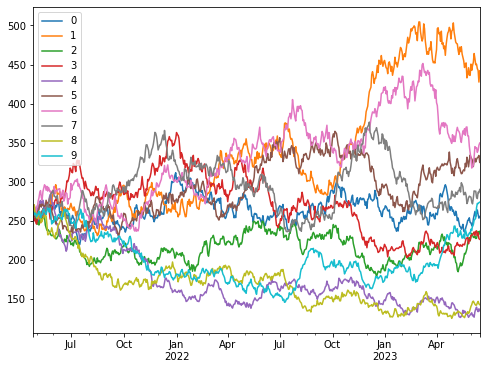

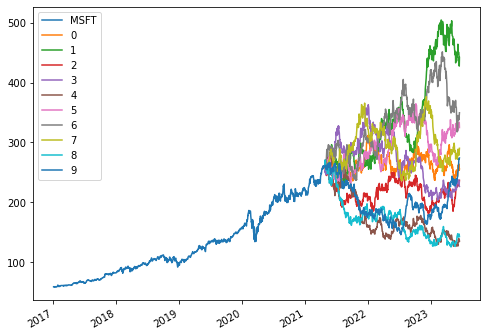

In [17]:
# graficas
sim_closes.plot(figsize=(8,6));
# Se muestran los precios simulados con los precios descargados
pd.concat([closes_micro,sim_closes]).plot(figsize=(8,6));

In [18]:
opcion_valuar

Strike                                                            260
Expiry                                            2023-06-16 00:00:00
Type                                                              put
Symbol                                            MSFT230616P00260000
Last                                                             39.5
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  262
Quote_Time                                        2021-04-27 17:43:16
Last_Trade_Date                                   2021-04-27 16:58:38
JSON                {'contractSymbol': 'MSFT230616P00260000', 'str...
Name: 1150, Length: 19, dtype: object

In [19]:
from datetime import date
Hoy = date.today()

# strike price de la opción
K = opcion_valuar['JSON']['strike']  

# Fechas a simular
dates = pd.date_range(start= Hoy, periods = ndays, freq='B')

# Escenarios y número de días
ndays = len(dates)
nscen = 100000

# Condición inicial del precio a simular
S0 = closes_micro.iloc[-1,0]  

# simular rendimientos
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)

# Simular precios
sim_closes = S0*np.exp(sim_ret.cumsum())

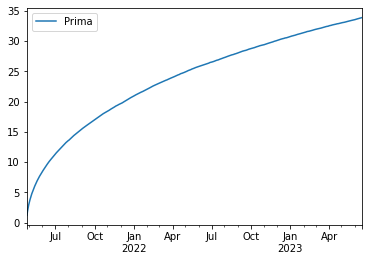

In [20]:
# Valor del put europeo
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(K-sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

La valuación de la opción es: 

In [21]:
put.iloc[-1]

Prima    33.895
Name: 2023-06-16 00:00:00, dtype: float64

Intervalo de confianza del 99%

In [22]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(32.85270361923429, 34.93688705980688)


## Precios simulados usando técnicas de reducción de varianza

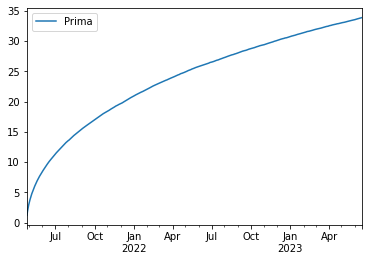

In [23]:
# Usando muestreo estratificado----> #estratros = nscen
U = (np.arange(0,nscen)+np.random.rand(ndays,nscen))/nscen
Z = st.norm.ppf(U)

sim_ret2 = pd.DataFrame(sigma*Z+r,index=dates)
sim_closes2 = S0*np.exp(sim_ret.cumsum())

# Función de pago
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike-sim_closes2,np.zeros([ndays,nscen])).T.mean()}, index=dates)
put.plot();

La valuacion de la opción es:

In [24]:
put.iloc[-1]

Prima    33.895
Name: 2023-06-16 00:00:00, dtype: float64

Intervalo de confianza 99%

In [25]:
confianza = 0.99
sigma_est = sim_closes2.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(32.85270361923429, 34.93688705980688)


### Análisis de la distribución de los rendimientos

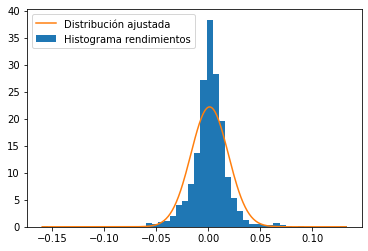

In [26]:
# ajustando norm 
ren = calc_daily_ret(closes_micro) # rendimientos 
y,x,_ = plt.hist(ren['MSFT'],bins=50,density=True,label='Histograma rendimientos')

mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal
# Valores máximo y mínimo de los rendiemientos a generar
ren_max = max(x);ren_min = min(x)
# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
# Generación de la normal ajustado con los parámetros encontrados
curve_fit = st.norm.pdf(ren_gen,loc=mu_fit,scale=sd_fit)
plt.plot(ren_gen,curve_fit,label='Distribución ajustada')
plt.legend()
plt.show()

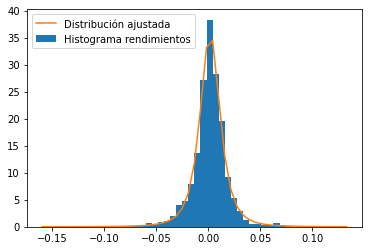

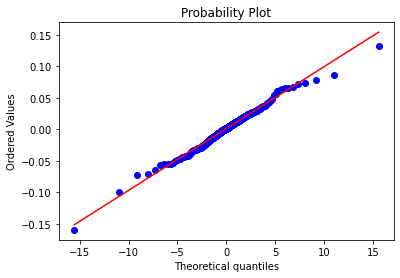

In [27]:
# ajustando t 
# rendimientos 
ren = calc_daily_ret(closes_micro) 

# Histograma de los rendimientos
y, x, _ = plt.hist(ren['MSFT'], bins=50, density=True, label='Histograma rendimientos')

# Se ajustan los parámetros de una distribución
dist = 't'
params = getattr(st, dist).fit(ren.values) 

# Generación de la pdf de la distribución ajustado con los parámetros encontrados
curve_fit = getattr(st, dist).pdf(x, *params)
plt.plot(x, curve_fit, label='Distribución ajustada')
plt.legend()
plt.show()

# Q-Q
st.probplot(ren['MSFT'], sparams=params[:-2], dist=dist, plot=plt);

## Valuación usando simulación: uso de histograma de rendimientos

In [28]:
ndays = len(dates) 
nscen = 10

prob = y/np.sum(y)
values = x[1:]
prob.sum()

1.0

In [29]:
# Rendimientos simulados
ret = np.random.choice(values, ndays*nscen, p=prob)
# Fechas
dates = pd.date_range(start=Hoy,periods=ndays)
# Rendimien en Data Frame
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_hist

,0,1,2,...,7,8,9
2021-04-27,-0.007,-0.013,0.010,...,-0.043,-0.031,0.034
2021-04-28,0.004,0.016,0.022,...,0.004,-0.002,0.010
2021-04-29,-0.019,0.016,-0.002,...,0.010,0.022,0.010
2021-04-30,-0.002,-0.002,0.022,...,-0.007,0.010,0.010
2021-05-01,0.016,-0.002,-0.002,...,0.016,0.028,-0.013
...,...,...,...,...,...,...,...
2022-11-02,-0.007,-0.007,0.016,...,0.028,-0.002,0.004
2022-11-03,0.010,-0.031,-0.002,...,0.045,0.016,0.010
2022-11-04,0.034,0.028,-0.002,...,-0.002,-0.007,-0.025
2022-11-05,-0.007,0.004,0.004,...,0.010,-0.002,-0.002


In [30]:
sim_closes_hist = (closes_micro.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
sim_closes_hist

,0,1,2,...,7,8,9
2021-04-27,259.553,258.040,264.147,...,250.605,253.553,270.398
2021-04-28,260.667,262.196,269.975,...,251.680,253.156,273.151
2021-04-29,255.733,266.418,269.552,...,254.242,258.741,275.931
2021-04-30,255.332,266.001,275.499,...,252.364,261.375,278.740
2021-05-01,259.444,265.584,275.068,...,256.428,268.709,275.068
...,...,...,...,...,...,...,...
2022-11-02,2716.429,3372.590,4790.046,...,1136.574,5290.697,2445.037
2022-11-03,2744.081,3270.281,4782.546,...,1189.143,5375.900,2469.927
2022-11-04,2837.619,3362.037,4775.058,...,1187.281,5336.187,2409.047
2022-11-05,2816.657,3376.460,4795.542,...,1199.367,5327.832,2405.275


Text(0.5, 1.0, 'Simulación usando el histograma de los rendimientos')

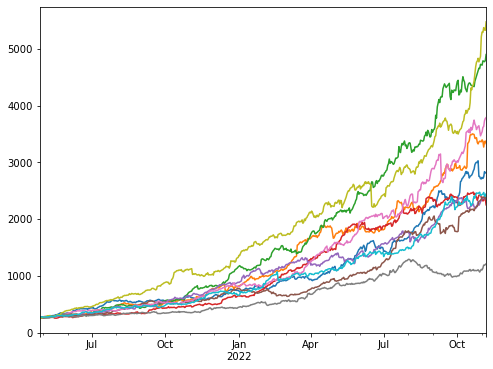

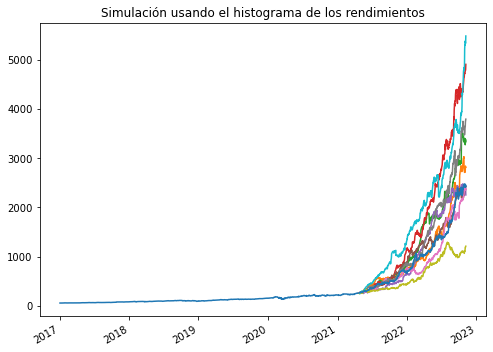

In [31]:
sim_closes_hist.plot(figsize=(8,6),legend=False);
pd.concat([closes_micro,sim_closes_hist]).plot(figsize=(8,6),legend=False);
plt.title('Simulación usando el histograma de los rendimientos')

In [32]:
K = opcion_valuar['JSON']['strike']
ndays = len(dates)
nscen = 100000

# Histograma tomando la tasa libre de riesgo
freq, values = np.histogram(ret_micro+r-mu, bins=2000)
prob = freq/np.sum(freq)

# Simulación de los rendimientos
ret = np.random.choice(values[1:], ndays*nscen, p=prob)

# Simulación de precios
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_micro.iloc[-1,0]) * np.exp(sim_ret_hist.cumsum())

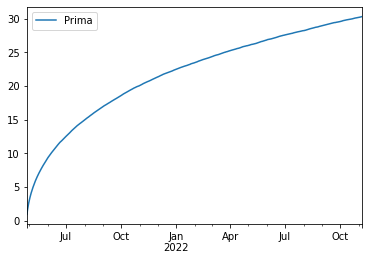

In [33]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays) \
                          *np.fmax(strike-sim_closes_hist,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
put_hist.plot();

In [34]:
put_hist.iloc[-1]

Prima    30.276
Name: 2022-11-06 00:00:00, dtype: float64

In [35]:
opcion_valuar['JSON']

{'contractSymbol': 'MSFT230616P00260000',
 'strike': 260.0,
 'currency': 'USD',
 'lastPrice': 39.45,
 'change': 0.47000122,
 'percentChange': 1.2057498,
 'volume': 75,
 'openInterest': 112,
 'bid': 38.0,
 'ask': 41.1,
 'contractSize': 'REGULAR',
 'expiration': 1686873600,
 'lastTradeDate': 1619542718,
 'impliedVolatility': 0.2771220970153808,
 'inTheMoney': False}

Intervalo de confianza de 95%

In [36]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)

(29.455264436125347, 31.09679698585375)


# Valor teórico

Para obtener el valor teorico simplemente sustituimos en las fórmulas de Blak & Scholes

$$
d_1 = \frac{\ln{\frac{S_0}{K}} + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}, \quad d_2 = \frac{\ln{\frac{S_0}{K}} + (r - \sigma^2 / 2) T}{\sigma \sqrt{T}} 
$$
Valor teórico de opción put
$$
p = K e^{-r*T} N(-d_2) - S_0 N(-d_1)
$$

$$
d_1 = \frac{\ln{\frac{261.51}{260}} + (\frac{0.0006}{360} + 0.018^2 / 2) 560}{0.018 \sqrt{560}} = 0.23
\quad d_2 = \frac{\ln{\frac{261.51}{260}} + (\frac{0.0006}{360} - 0.018^2 / 2) 560}{0.018 \sqrt{560}} = -0.20
$$

In [39]:
sigma_R

0.017986980386435876

$$ 
p = 260 e^{\frac{0.0006}{360}*560} * 0.5793 - (261.51*0.4090) = 43.5198
$$

Nota: los valores de $N(-d_1)$ y $N(-d_1)$ fueron obtenidos de tablas de distribución normal. 

# Comparación 

In [47]:
comp = pd.DataFrame(index=['Vo'], columns = ['Valoración B&S', 'Reducción de Var', 'Histograma de rend', 'Valor Teórico'])
comp['Valoración B&S'] = '33.895'
comp['Reducción de Var'] = '33.895'
comp['Histograma de rend'] = '30.276'
comp['Valor Teórico'] = '43.5198'
comp

,Valoración B&S,Reducción de Var,Histograma de rend,Valor Teórico
Vo,33.895,33.895,30.276,43.5198


Dado que el valor real de la opción es de **39.45**, podemos observar que si bien las estimaciones no son identicas, el valor se aproxima lo suficiente. 
Entre el valor teórico y los valores obtenidos por medio de simulaciones hay una diferencia de aproximadamente 10 unidades. 

### Solución Diego Pintor


In [3]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [4]:
aapl = web.YahooOptions('AAPL')
aapl_opt = aapl.get_all_data().reset_index()
aapl_opt = aapl_opt.set_index('Expiry')

In [52]:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]
ticker = ['AAPL']
start_date = '2017-01-01'
closes_aapl = get_adj_closes(ticker, start_date)
ret_aapl = calc_daily_ret(closes_aapl)
# Obtenemos el rendimiento simple
Ri = closes_aapl.pct_change(1).iloc[1:]
# Obtenemos su media y desviación estándar de los rendimientos
mu = ret_aapl.mean()[0]
sigma = ret_aapl.std()[0]
mu, sigma

aapl_opt = aapl.get_all_data().reset_index()
K = 135
indice_opt = aapl_opt.loc[(aapl_opt.Type=='put') & (aapl_opt.Strike==K) & (aapl_opt.Expiry=='2022-09-16')]
i_opt= indice_opt.index
opcion_valuar = aapl_opt.loc[i_opt[0]]

In [77]:
# Fechas de simulaciones
from datetime import date
today = pd.to_datetime(date.today())

# Obtener fecha de cierre de la opción a valuar
expiry = opcion_valuar.Expiry
dates = pd.date_range(today, expiry, freq='B')

ndays = len(dates)
dates = pd.date_range(start= Hoy, periods = ndays, freq='B')
# Generando histograma de rendimientos
ren = calc_daily_ret(closes_aapl) 
y, x = np.histogram(ren['AAPL'], bins=50, density=True)

In [79]:
prob = y/np.sum(y)
values = x[1:]


In [80]:
nscen = 10000
# Rendimientos simulados
ret = np.random.choice(values, ndays*nscen, p=prob)
# Fechas
dates = pd.date_range(start=Hoy,periods=ndays)
# Rendimien en Data Frame
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_hist
sim_closes_hist = (closes_aapl.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())


In [81]:
K = opcion_valuar['JSON']['strike']
ndays = len(dates)
nscen = 100000


# Tasa de bonos de 1 yr de fecha 21/04/2021 -> 7%
r = 0.007/360 # Tasa diaria

# Histograma tomando la tasa libre de riesgo
freq, values = np.histogram(ret_aapl+r-mu, bins=2000)
prob = freq/np.sum(freq)

# Simulación de los rendimientos
ret = np.random.choice(values[1:], ndays*nscen, p=prob)


# Simulación de precios
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_aapl.iloc[-1,0]) * np.exp(sim_ret_hist.cumsum())

In [82]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays) \
                          *np.fmax(strike-sim_closes_hist,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)


In [83]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)


(14.460483030456672, 15.189275057312912)
(14.460483030456672, 15.189275057312912)


In [84]:
opcion_valuar["JSON"]

{'contractSymbol': 'AAPL220916P00135000',
 'strike': 135.0,
 'currency': 'USD',
 'lastPrice': 19.4,
 'change': 0.0,
 'percentChange': 0.0,
 'volume': 2,
 'openInterest': 1621,
 'bid': 19.5,
 'ask': 19.75,
 'contractSize': 'REGULAR',
 'expiration': 1663286400,
 'lastTradeDate': 1619465019,
 'impliedVolatility': 0.3105232522583008,
 'inTheMoney': True}

In [120]:
call_hist.iloc[-1].values

array([14.82487904])

### Comparando Resultados con Black Scholes

In [117]:
# Datos para usar en la fórmula (anualizados)
vol = ren["AAPL"].std()*np.sqrt(252)
media = ren["AAPL"].mean()*252
maduracion = ndays
st = closes_aapl.iloc[-1,0]
rf = r*360
print("Volatilidad anual",vol)
print("Tiempo de maduración",maduracion,"días")
print("Spot price",st)
print("Strike Price",K)
print("Tasa Libre de riesgo",r*360*100)


Volatilidad anual 0.31638434493720957
Tiempo de maduración 364 días
Spot price 134.7050018310547
Strike Price 135.0
Tasa Libre de riesgo 0.7000000000000001


In [122]:
#Black Scholes
from scipy.stats import norm
d1 = (np.log(st/K)+(rf+(vol**2)/2))/vol
d2 = d1-vol
put = K*np.exp(-rf)*norm.cdf(-d2)-st*norm.cdf(-d1)
print("El valor de la opción con Black Scholes es:",put,"y el valor de la opción simulado es de:",call_hist.iloc[-1].values)

El valor de la opción con Black Scholes es: 16.56963837424412 y el valor de la opción simulado es de: [14.82487904]
